In [ ]:
##!pip install ipywidgets
from google.colab import output
output.enable_custom_widget_manager()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.optimize import least_squares
import tensorflow as tf
from tensorflow.keras import layers, models
from ipywidgets import interact, FloatSlider

# ------------------------------
# Paramètres globaux
# ------------------------------
fs = 8000
T = 1.0
t = np.linspace(0, T, int(fs*T))
c = 1480
sensor_pos = np.array([0.0, 0.5, 1.0])   # 3 capteurs
L = 1.0


In [ ]:
# ------------------------------
# Signal fuite (mélange basse fréquence + moyenne fréquence)
# ------------------------------
def make_pulse(t):
    low = np.sin(2*np.pi*40*t) * np.exp(-(t-0.25)**2 / 0.005)
    mid = 0.5*np.sin(2*np.pi*120*t) * np.exp(-(t-0.12)**2 / 0.01)
    return low + mid

base = make_pulse(t)

def lowpass(sig, cutoff=90):
    b,a = butter(4, cutoff/(fs/2), btype="low")
    return filtfilt(b,a,sig)

# ------------------------------
# Génération signaux bruités (difficiles pour GCC-PHAT)
# ------------------------------
def generate_signal(real_pos, SNR):
    signals = []
    for sp in sensor_pos:
        dist = abs(real_pos - sp)
        delay = dist / c
        delay_samp = int(delay * fs)

        sig = np.zeros_like(base)
        if delay_samp < len(sig):
            sig[delay_samp:] = base[:len(sig)-delay_samp]

        sig = lowpass(sig, cutoff=80)

        # bruit coloré -> GCC-PHAT est mauvais ici
        noise = np.random.normal(0,1,len(sig))
        noise = lowpass(noise, cutoff=150)

        Ps = np.mean(sig**2)
        Pn = Ps / (10**(SNR/10))
        sig += noise * np.sqrt(Pn)

        signals.append(sig)

    return np.array(signals)


In [ ]:
# ------------------------------
# GCC-PHAT standard
# ------------------------------
def gcc_phat(x, y):
    N = x.size + y.size
    X = np.fft.rfft(x, N)
    Y = np.fft.rfft(y, N)
    R = X * np.conj(Y)
    R /= np.abs(R) + 1e-12
    cc = np.fft.irfft(R, N)
    shift = np.argmax(cc) - N//2
    return shift / fs


def estimate_GCC(signals):
    tdoas = []
    for i in range(len(signals)):
        if i == 0:
            tdoas.append(0)
        else:
            tdoas.append(gcc_phat(signals[0], signals[i]))
    tdoas = np.array(tdoas)

    xs = np.linspace(0,1,2000)
    errors = []

    for x in xs:
        d = np.abs(x - sensor_pos)
        d0 = d[0]
        pred = d - d0
        errors.append(np.sum((pred - tdoas*c)**2))

    return xs[np.argmin(errors)]


/tmp/ipython-input-2420096911.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_cnn = float(model.predict(X_test, verbose=0)[0])


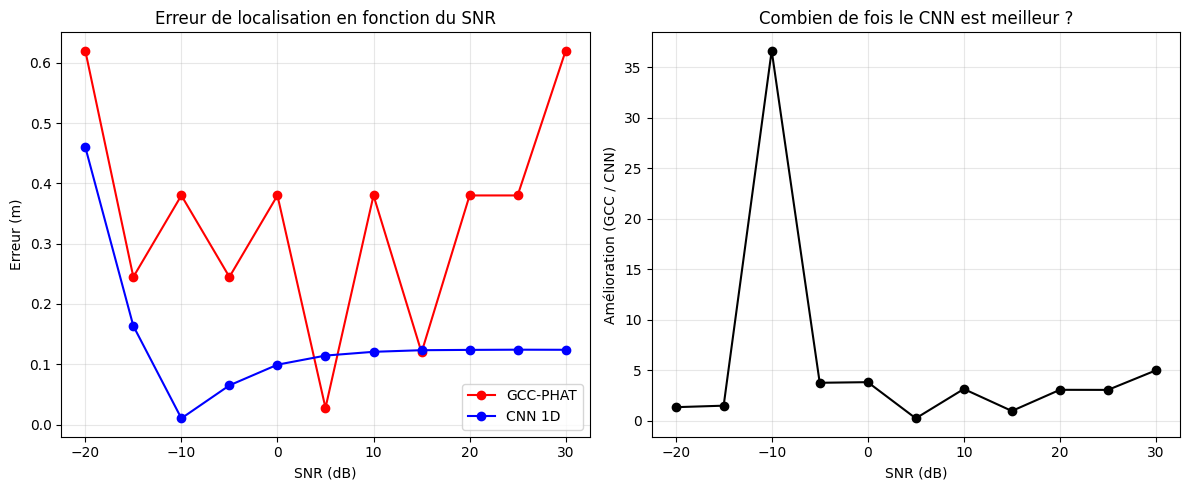

In [ ]:
def evaluate_over_SNRs():
    SNR_values = np.arange(-20, 31, 5)

    errors_gcc = []
    errors_cnn = []

    real_pos = 0.62

    for SNR in SNR_values:

        signals = generate_signal(real_pos, SNR)

        est_gcc = estimate_GCC(signals)
        err_gcc = abs(est_gcc - real_pos)
        errors_gcc.append(err_gcc)

        X_test = signals.flatten().reshape(1,-1,1)
        est_cnn = float(model.predict(X_test, verbose=0)[0])
        err_cnn = abs(est_cnn - real_pos)
        errors_cnn.append(err_cnn)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(SNR_values, errors_gcc, "r-o", label="GCC-PHAT")
    plt.plot(SNR_values, errors_cnn, "b-o", label="CNN 1D")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Erreur (m)")
    plt.grid(True, alpha=0.3)
    plt.title("Erreur de localisation en fonction du SNR")
    plt.legend()

    plt.subplot(1,2,2)
    ratio = np.array(errors_gcc)/(np.array(errors_cnn)+1e-12)
    plt.plot(SNR_values, ratio, "k-o")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Amélioration (GCC / CNN)")
    plt.grid(True, alpha=0.3)
    plt.title("Combien de fois le CNN est meilleur ?")

    plt.tight_layout()
    plt.show()


evaluate_over_SNRs()
